# COMPS II
### A notebook for producing paper-quality figures and captions for my upcoming COMPS-II paper.
##### Initialized by Drew Camron Sep 2018

In [1]:
%matplotlib inline
import os

import xarray as xr
import pandas as pd
import numpy as np

from pyresample import geometry, image
roi=10e6    # For any radius_of_influence pyresample calculations

import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs

In [2]:
sns.set(context='poster', style='white')

In [3]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:34720 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 72 Cores: 72 Memory: 135.08 GB


In [4]:
indir_rcp = '/glade/p/cesm/pcwg_dev/jenkay/COSP/cesm112lens/runs_LENS_n16_cosp1.4_opaq_precboth/b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_agl_precboth_opaq/atm/proc/tseries/month_1/'
indir_1850 = '/glade/p/cesm/pcwg_dev/jenkay/COSP/cesm112lens/runs_LENS_n16_cosp1.4_opaq_precboth/b.e11.B1850LENS.f09_g16.001_cosp1.4_opaq_prec_agl_precboth_opaq/atm/proc/tseries/month_1/'
indir_obs = '/glade/work/mcamron/obs/cloudsat/tristan/'
indir_mask = '/glade/work/mcamron/gismask_RACMO23_0.9x1.25_con.nc'
indir_topo = '/glade/work/mcamron/USGS-gtopo30_0.9x1.25_remap_c051027.nc'

In [5]:
ds_vars = ['RADAR_LGTRAIN', 'RADAR_LGTRAINO', 'RADAR_RAIN', 'RADAR_RAINO', 'RADAR_LGTSNOW', 'RADAR_LGTSNOWO', 'RADAR_SNOW', 'RADAR_SNOWO']

fn_tseries_rcp = 'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_agl_precboth_opaq.cam.h0.'
fn_tseries_1850 = 'b.e11.B1850LENS.f09_g16.001_cosp1.4_opaq_prec_agl_precboth_opaq.cam.h0.'
fext_tseries_rcp = '.200601-209512.nc'
fext_tseries_1850 = '.000101-010012.nc'

fnames_rcp = [indir_rcp + fn_tseries_rcp + var + fext_tseries_rcp for var in ds_vars]
fnames_1850 = [indir_1850 + fn_tseries_1850 + var + fext_tseries_1850 for var in ds_vars]

obs_ls = []
for yr in [('%02d' % a) for a in range(6, 17)]:
    for mo in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']:
        obs_ls = obs_ls + [indir_obs+file for file in os.listdir(indir_obs) if mo+yr in file]

ds_rcp = xr.open_mfdataset(fnames_rcp, decode_times=False).sel(lat=slice(0, 90))
newlons = [(lon - 360) if (lon > 179) else lon for lon in ds_rcp.lon.values]
ds_rcp = ds_rcp.assign_coords(lon=newlons).roll(lon=(ds_rcp.dims['lon'] // 2))
ds_1850 = xr.open_mfdataset(fnames_1850, decode_times=False).sel(lat=slice(0, 90))
ds_1850 = ds_1850.assign_coords(lon=newlons).roll(lon=(ds_1850.dims['lon'] // 2))
ds_obs = xr.open_mfdataset(obs_ls, concat_dim='time')

ds_rcp['time'] = pd.date_range('2006-01', '2095-12', freq='MS')
ds_1850['time'] = pd.date_range('2006-01', '2105-12', freq='MS')
ds_obs['time'] = pd.date_range('2006-06', '2016-05', freq='MS')

ds_obs['latitude'] = ds_obs['latitude'][0].reset_coords('time', drop=True)
ds_obs['longitude'] = ds_obs['longitude'][0].reset_coords('time', drop=True)
ds_obs = ds_obs.swap_dims({'nlats': 'latitude', 'nlons': 'longitude'}).sel(latitude=slice(0, 90))
#ds_obs = ds_obs.assign_coords(longitude=(ds_obs.longitude % 360)).roll(longitude=(ds_obs.dims['longitude'] // 2))

ds_mask = xr.open_dataset(indir_mask).sel(lat=slice(0, 90))
ds_mask = ds_mask.assign_coords(lon=newlons).roll(lon=(ds_mask.dims['lon'] // 2))
#ms = ds_mask['GrIS_mask'].where(ds_mask['GrIS_mask'] > 0)

ds_topo = xr.open_dataset(indir_topo)
ds_topo = (ds_topo
           .sel(lat=(ds_topo['lat'] > 0))
           .assign_coords(lat=ds_rcp['lat'])
           .assign_coords(lon=newlons)
           .roll(lon=(ds_topo.dims['lon'] // 2)))

In [6]:
ds_pres = ds_rcp.isel(time=slice(0, 180))
ds_fut = ds_rcp.isel(time=slice(-181, -1))

rain_pres = (
    ds_pres['RADAR_RAIN'] + ds_pres['RADAR_LGTRAIN']) / 100
snow_pres = (
    ds_pres['RADAR_SNOW'] + ds_pres['RADAR_LGTSNOW']) / 100

rain_fut = (
    ds_fut['RADAR_RAIN'] + ds_fut['RADAR_LGTRAIN']) / 100
snow_fut = (
    ds_fut['RADAR_SNOW'] + ds_fut['RADAR_LGTSNOW']) / 100

rain_obs = (
    (ds_obs['raincounts'] + #ds_obs['heavyraincounts'] +    # heavy rain is a subset of rain certain
     ds_obs['probablecounts'] + ds_obs['possiblecounts']) / ds_obs['counts'])
snow_obs = (
    (ds_obs['snowcounts'] + ds_obs['snowpossiblecounts']) / ds_obs['counts'])

---
## Figure 1
`CLOUDSAT` sum rain frequency and sum snow frequency maps, shown annually and seasonally.

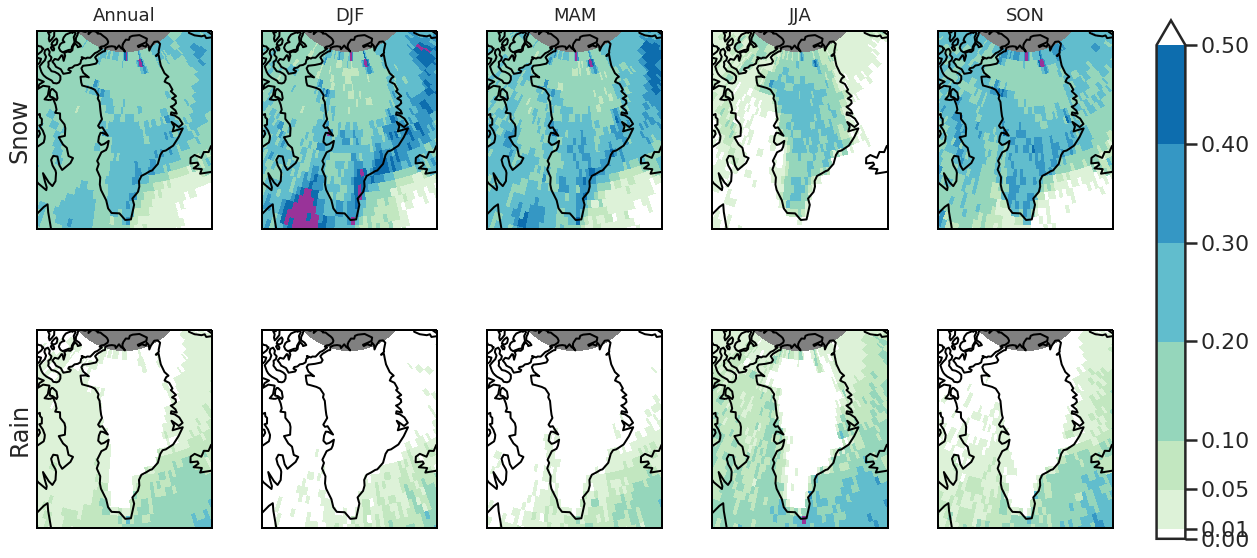

In [7]:
f, axes = plt.subplots(
            nrows=2, ncols=5, figsize=(16, 9),
            subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=315)}
            )

seasons = ['DJF', 'MAM', 'JJA', 'SON']

levels = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
colors = [(1, 1, 1)] 
colors += sns.color_palette('GnBu', len(levels) - 2)
colors += [(153/255, 51/255, 153/255)]

(snow_obs
 .mean('time')
 .plot.pcolormesh(
     ax=axes[0, 0], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
     levels=levels, colors=colors)
)

for i, x in enumerate(seasons):
    (snow_obs
    .groupby('time.season')
    .mean('time')
    .sel(season=x)
    .plot.pcolormesh(
        ax=axes[0, i+1], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
        levels=levels, colors=colors)
    )
    

p = (rain_obs
    .mean('time')
    .plot.pcolormesh(
        ax=axes[1, 0], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
        levels=levels, colors=colors)
    )

for i, x in enumerate(seasons):
    (rain_obs
    .groupby('time.season')
    .mean('time')
    .sel(season=x)
    .plot.pcolormesh(
        ax=axes[1, i+1], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
        levels=levels, colors=colors)
    )
      
for ax in axes.flat:
    ax.coastlines(linewidth=2)
    ax.set_extent([295, 335, 57, 84])
    ax.background_patch.set_facecolor('gray')

plt.tight_layout()
    
cb_ax = f.add_axes([1.005, 0.1, 0.025, 0.8])
cb = f.colorbar(p, cax=cb_ax, extend='max', spacing='proportional')
    
axes[0, 0].text(-0.1, 0.5, 'Snow', fontsize=24, 
                rotation='vertical', ha='center', va='center', transform=axes[0, 0].transAxes)
axes[1, 0].text(-0.1, 0.5, 'Rain', fontsize=24,
                rotation='vertical', ha='center', va='center', transform=axes[1, 0].transAxes)

for ax, xlab in zip(axes[0, :], ['Annual', 'DJF', 'MAM', 'JJA', 'SON']):
    ax.text(0.5, 1.03, xlab, fontsize=18, transform=ax.transAxes, ha='center', va='bottom')


f.savefig('../figures/comps2/Figure1_mapgrid-cloudsat.png',
         bbox_extra_artists=[ax for l in axes for ax in l], bbox_inches='tight')

---
## Figure 2
Greenland mean seasonal cycle separated by variable.

In [8]:
obs_mask_indir = '/glade/work/mcamron/Drew_GrIS_masks/Icemask_Topo_GrIS_CC_final.nc'
obs_mask = xr.open_dataset(obs_mask_indir).sel(lat=slice(0, 90)).rename({'lon': 'longitude', 'lat': 'latitude'})

In [9]:
w_in = np.tile((ds_rcp['gw']), [len(ds_rcp['lon']), 1]).T
w = w_in / w_in.sum() / 2

x, y = np.meshgrid((ds_mask['lon'].values.astype('float32')), ds_mask['lat'])
xx, yy = np.meshgrid(ds_obs['longitude'], ds_obs['latitude']) 

ms_grid = geometry.GridDefinition(lons=x, lats=y)
obs_grid = geometry.GridDefinition(lons=xx, lats=yy)

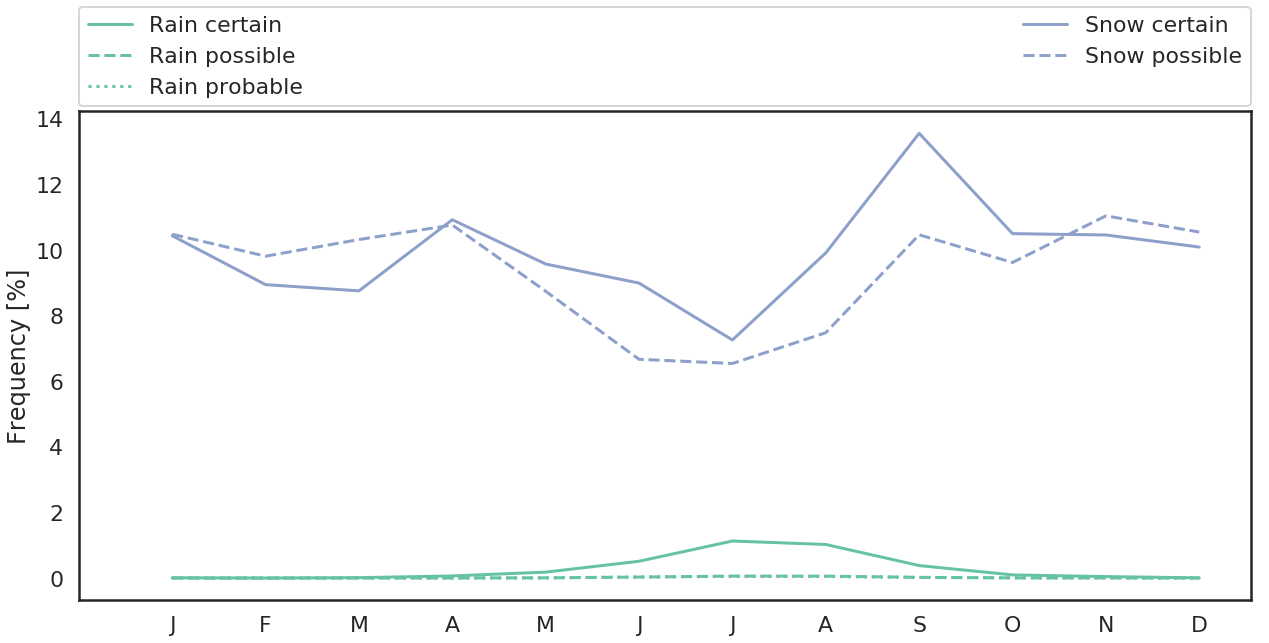

In [10]:
f, ax = plt.subplots(figsize=(21, 9))

obs_vars = ['raincounts', 'possiblecounts', 'probablecounts', 'snowcounts', 'snowpossiblecounts']
obs_vnames = ['Rain certain', 'Rain possible', 'Rain probable', 'Snow certain', 'Snow possible']
obs_lstyle = ['solid', 'dashed', 'dotted', 'solid', 'dashed']
obs_colors = [0, 0, 0, 2, 2]
for var, name, style, color in zip(obs_vars, obs_vnames, obs_lstyle, obs_colors):
    ((
        ((ds_obs[var] / ds_obs['counts']) * 100 * obs_mask['mask'].where(obs_mask['mask'] > 0) * obs_mask['cell_area'])
        .sum('latitude').sum('longitude') / (obs_mask['mask'] * obs_mask['cell_area']).sum())
        .groupby('time.month')
        .mean('time', skipna=True)
        .plot(ax=ax, label=name, color=sns.color_palette('Set2')[color], linestyle=style)
    )
    
ax.autoscale(enable=True)    

ax.legend(bbox_to_anchor=(0., 1.01, 1., .101), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xticks(np.arange(13), ['', 'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax.set_ylabel('Frequency [%]')
ax.set_xlabel('')

f.savefig('../figures/comps2/Figure2_GIS-mean-cycle.png', bbox_inches='tight')

---
## Figure 3
Top: a distribution of precip frequencies by elevation. Bottom: distribution of total area of grids by elevation.

In [11]:
bins = np.arange(0, 3750, 250)

---
## Figure 4
CESM 1 `present` bias maps relative to `CLOUDSAT` observations, ie as in **Figure 1** (CESM `present` - `CLOUDSAT`).

---
## Figure 5
CESM 1 `present` mean seasonal cycle, ie as in **Figure 2**.

In [12]:
model_mask_indir = '/glade/work/mcamron/Drew_GrIS_masks/Icemask_Topo_GrIS_SM_final.nc'
model_mask = xr.open_dataset(model_mask_indir)
model_mask = (model_mask
              .sel(lat=(model_mask['lat'] >= 0))
              .assign_coords(lat=ds_pres.lat)
              .assign_coords(lon=newlons)
              .roll(lon=(model_mask.dims['lon'] // 2))
             )

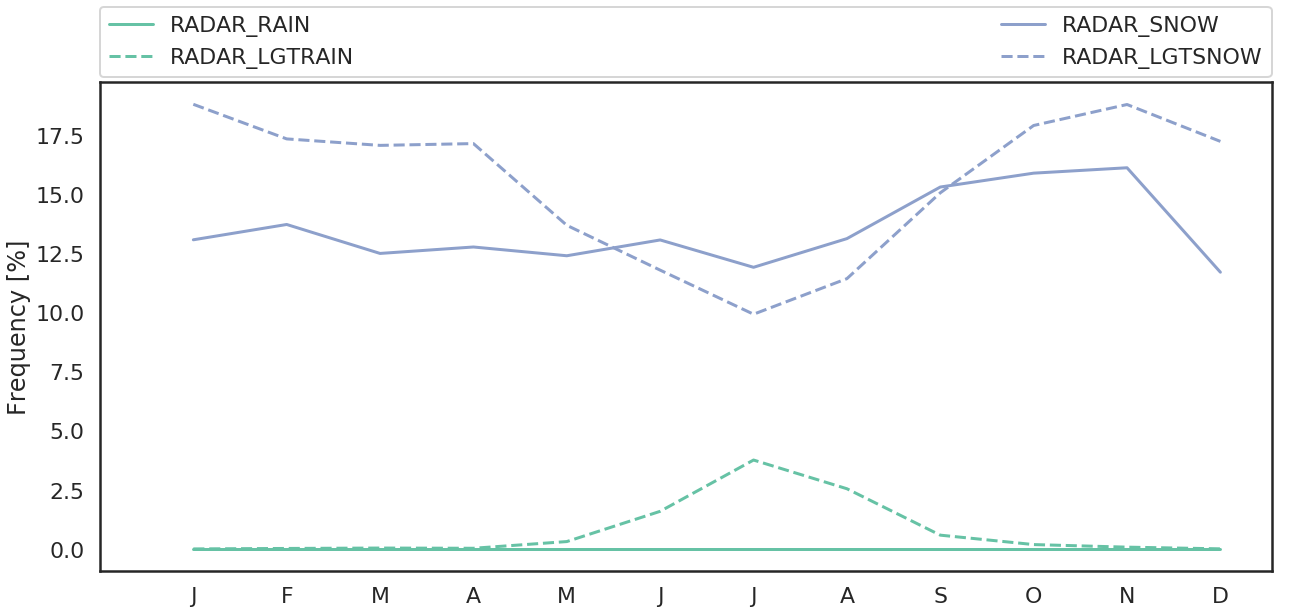

In [13]:
f, ax = plt.subplots(figsize=(21, 9))

model_vars = ['RADAR_RAIN', 'RADAR_LGTRAIN', 'RADAR_SNOW', 'RADAR_LGTSNOW']
model_lstyle = ['solid', 'dashed', 'solid', 'dashed']
model_colors = [0, 0, 2, 2]
for var, style, color in zip(model_vars, model_lstyle, model_colors):
    ((
        (ds_pres[var] * model_mask['mask'].where(model_mask['mask'] > 0) * model_mask['cell_area'])
        .sum('lat').sum('lon') / (model_mask['mask'] * model_mask['cell_area']).sum())
        .groupby('time.month')
        .mean('time', skipna=True)
        .plot(ax=ax, label=var, color=sns.color_palette('Set2')[color], linestyle=style)
    )
    
ax.autoscale(enable=True)    

ax.legend(bbox_to_anchor=(0., 1.01, 1., .101), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xticks(np.arange(13), ['', 'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax.set_ylabel('Frequency [%]')
ax.set_xlabel('')

f.savefig('../figures/comps2/Figure5_GIS-mean-cycle.png', bbox_inches='tight')

---
## Supplemental

### Supp to Fig 3
Exploring topography distributions

In [14]:
indir_1km = '/glade/work/mcamron/Drew_GrIS_masks/Icemask_Topo_Iceclasses_lon_lat_average_1km_GrIS.nc'
indir_1km_mask = '/glade/work/mcamron/Drew_GrIS_masks/Icemask_orig.nc'
ds_1km = xr.open_dataset(indir_1km)
ds_1km = ds_1km.assign_coords(lon=ds_1km['LON']).assign_coords(lat=ds_1km['LAT'])
mask_1km = xr.open_dataarray(indir_1km_mask)

In [15]:
g = 9.80665
topo_cesm = ds_topo['PHIS'] / g

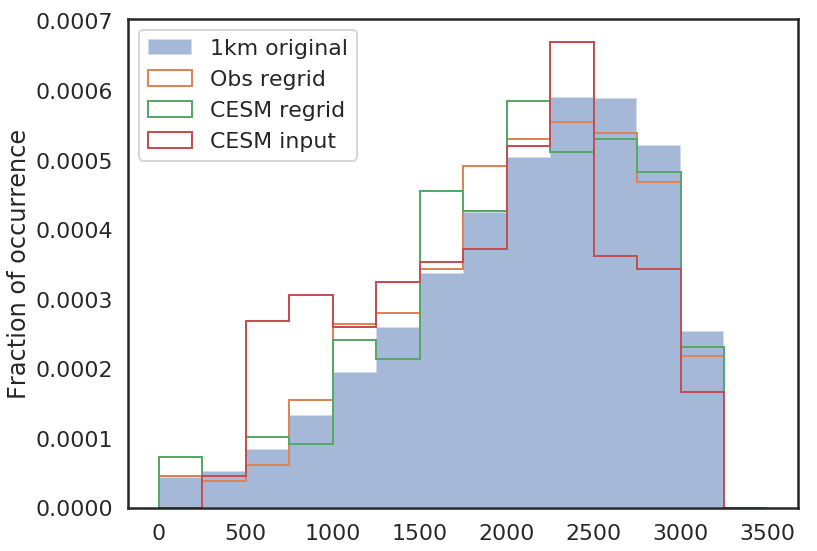

In [16]:
f, ax = plt.subplots(figsize=(12, 9))

_ = ((ds_1km['Topography'].where(mask_1km > 0))
     .plot.hist(ax=ax, bins=bins, histtype='stepfilled', density=True,
                linewidth=2, label='1km original', alpha=0.5))
_ = ((obs_mask['Topography'].where(obs_mask['mask'] > 0))
     .plot.hist(ax=ax, bins=bins, histtype='step', density=True,
                linewidth=2, label='Obs regrid'))
_ = ((model_mask['Topography'].where(model_mask['mask'] > 0))
     .plot.hist(ax=ax, bins=bins, histtype='step', density=True,
                linewidth=2, label='CESM regrid'))
_ = ((topo_cesm.where(model_mask['mask'] > 0))
     .plot.hist(ax=ax, bins=bins, histtype='step', density=True,
                linewidth=2, label='CESM input'))

ax.legend(loc='upper left')
ax.set_ylabel('Fraction of occurrence')
ax.set_title('')

f.savefig('../figures/comps2/Supp_3_topo-hist.png')

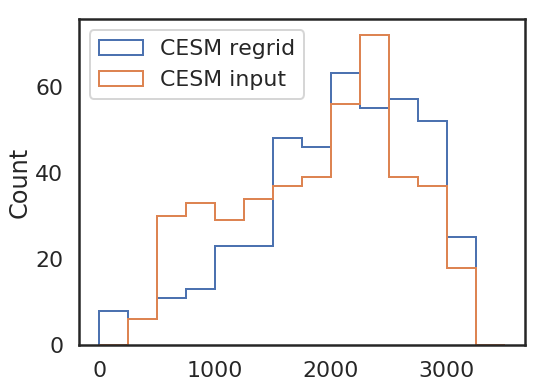

In [17]:
f, ax = plt.subplots(figsize=(8, 6))

_ = ((model_mask['Topography'] * model_mask['mask'].where(model_mask['mask'] > 0))
     .plot.hist(ax=ax, bins=bins, histtype='step',
                linewidth=2, label='CESM regrid'))
_ = ((topo_cesm * model_mask['mask'].where(model_mask['mask'] > 0))
     .plot.hist(ax=ax, bins=bins, histtype='step',
                linewidth=2, label='CESM input'))

ax.legend(loc='upper left')
ax.set_title('')

f.savefig('../figures/comps2/Supp_3_topo_1km-vs-cesm.png')

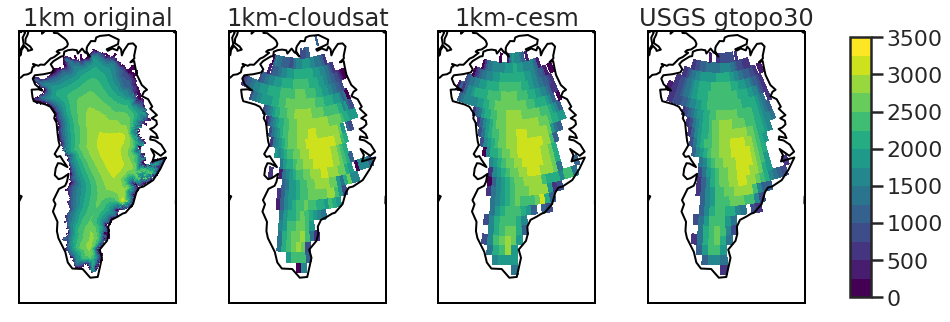

In [18]:
f, axes = plt.subplots(
            ncols=4, figsize=(12, 9),
            subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=315)})

levels = bins
p = (ds_1km['Topography'].where(mask_1km > 0)
     .plot.pcolormesh(x='lon', y='lat', ax=axes[0], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
                     levels=levels))
_ = (obs_mask['Topography'].where(obs_mask['mask'] > 0)
     .plot.pcolormesh(ax=axes[1], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
                     levels=levels))
_ = (model_mask['Topography'].where(model_mask['mask'] > 0)
     .plot.pcolormesh(ax=axes[2], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
                     levels=levels))
_ = (topo_cesm.where(model_mask['mask'] > 0)
     .plot.pcolormesh(ax=axes[3], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
                     levels=levels))

titles = ['1km original', '1km-cloudsat', '1km-cesm', 'USGS gtopo30']
for i, ax in enumerate(axes.flat):
    ax.coastlines(linewidth=2)
    ax.set_extent([303, 330, 57, 84])
    ax.set_title(titles[i])

plt.tight_layout()
    
cb_ax = f.add_axes([1.005, 0.3, 0.025, 0.4])
cb = f.colorbar(p, cax=cb_ax)

f.savefig('../figures/comps2/Supp_3_topo-maps.png')

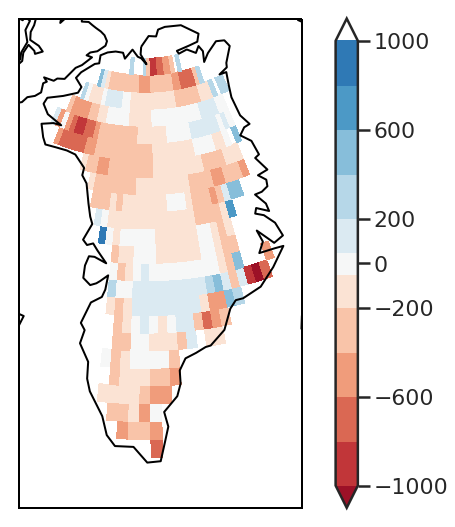

In [19]:
f, ax = plt.subplots(
            figsize=(12, 9),
            subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=315)})

levels = [-1000, -800, -600, -400, -200, -50, 50, 200, 400, 600, 800, 1000]
colors = sns.color_palette('RdBu', len(levels)+1)

p = ((topo_cesm - model_mask['Topography']).where(model_mask['mask'] > 0)
     .plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
                      levels=levels, colors=colors))

ax.coastlines(linewidth=2)
ax.set_extent([303, 330, 57, 84])
    
cb = plt.colorbar(p, extend='both', spacing='proportional', ticks=[-1000, -600, -200, 0, 200, 600, 1000])

f.savefig('../figures/comps2/Supp_3_topo-usgs-bias.png')

### Supp to Fig 4
Maps of CESM 1 `present` (non-bias).

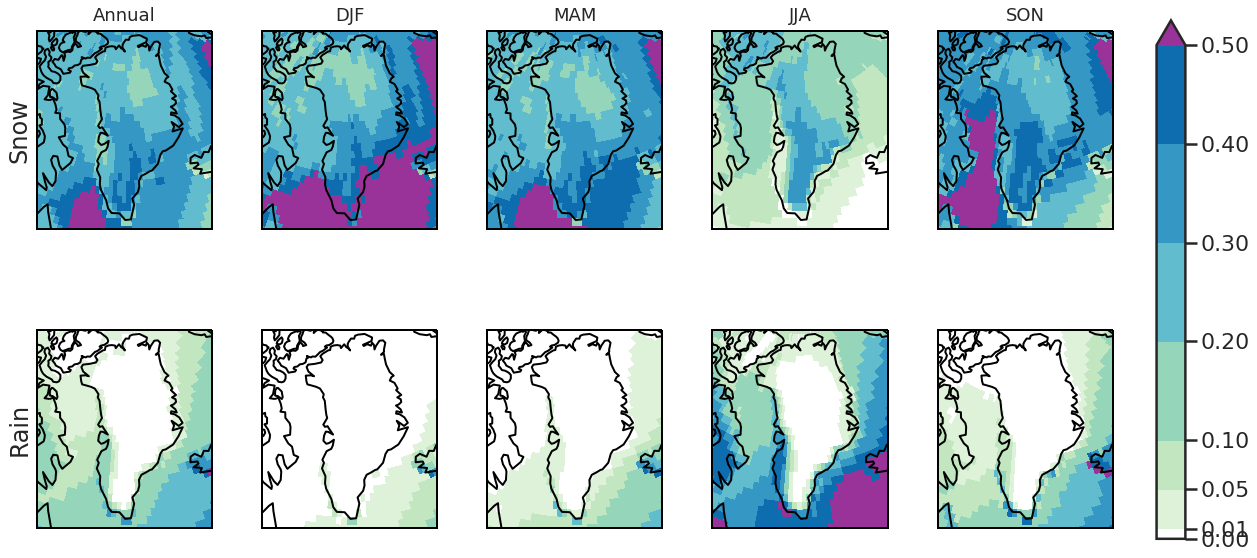

In [20]:
f, axes = plt.subplots(
            nrows=2, ncols=5, figsize=(16, 9),
            subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=315)})

levels = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
colors = [(1, 1, 1)] 
colors += sns.color_palette('GnBu', len(levels) - 2)
colors += [(153/255, 51/255, 153/255)]

(snow_pres
 .mean('time')
 .plot.pcolormesh(
     ax=axes[0, 0], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
     levels=levels, colors=colors)
)

for i, x in enumerate(seasons):
    (snow_pres
    .groupby('time.season')
    .mean('time')
    .sel(season=x)
    .plot.pcolormesh(
        ax=axes[0, i+1], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
        levels=levels, colors=colors)
    )
    
p = (rain_pres
    .mean('time')
    .plot.pcolormesh(
        ax=axes[1, 0], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
        levels=levels, colors=colors)
    )

for i, x in enumerate(seasons):
    (rain_pres
    .groupby('time.season')
    .mean('time')
    .sel(season=x)
    .plot.pcolormesh(
        ax=axes[1, i+1], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
        levels=levels, colors=colors)
    )
        
for ax in axes.flat:
    ax.coastlines(linewidth=2)
    ax.set_extent([295, 335, 57, 84])

plt.tight_layout()
    
cb_ax = f.add_axes([1.005, 0.1, 0.025, 0.8])
cb = f.colorbar(p, cax=cb_ax, extend='max', spacing='proportional')
    
axes[0, 0].text(-0.1, 0.5, 'Snow', fontsize=24, 
                rotation='vertical', ha='center', va='center', transform=axes[0, 0].transAxes)
axes[1, 0].text(-0.1, 0.5, 'Rain', fontsize=24,
                rotation='vertical', ha='center', va='center', transform=axes[1, 0].transAxes)

for ax, xlab in zip(axes[0, :], ['Annual', 'DJF', 'MAM', 'JJA', 'SON']):
    ax.text(0.5, 1.03, xlab, fontsize=18, transform=ax.transAxes, ha='center', va='bottom')


f.savefig('../figures/comps2/Supp_4_mapgrid-present.png',
         bbox_extra_artists=[ax for l in axes for ax in l], bbox_inches='tight')